<img src="https://www.e4ds.com/news_photo/U77C53G6CP8ASEHUJ5B7.png">

In [1]:
import torch
import pandas as pd
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F 
import matplotlib.pylab as plt 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Preparing the Data

In [2]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1 # Image channel
N_CLASSES = 24

train_df = pd.read_csv("./data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("./data/asl_data/sign_mnist_valid.csv")

class MyDataset(Dataset):
  def __init__(self, base_df):
    x_df = base_df.copy()
    y_df = x_df.pop('label')
    x_df = x_df.values / 255 # Normalize values from 0 to 1
    x_df = x_df.reshape(-1, IMG_CHS,IMG_HEIGHT, IMG_WIDTH)
    self.xs = torch.tensor(x_df).to(torch.float32).to(device)
    self.ys = torch.tensor(y_df).to(device)
    
  def __getitem__(self, idx):
    x = self.xs[idx]
    y = self.ys[idx]
    return x, y
  
  def __len__(self):
    return len(self.xs)

In [3]:
BATCH_SIZE = 32

train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
train_n = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size = BATCH_SIZE)
valid_n = len(valid_loader.dataset)

In [4]:
class MyConvBlock(nn.Module):
  def __init__(self, in_ch, out_ch, dropout_p):
    kernel_size = 3
    super().__init__()
    
    self.model = nn.Sequential(
      nn.Conv2d(in_ch, out_ch, kernel_size, stride = 1, padding = 1),
      nn.BatchNorm2d(out_ch),
      nn.ReLU(),
      nn.Dropout(dropout_p),
      nn.MaxPool2d(2, stride = 2) # stride = 2이면 output의 크기 1/2로 줄어듬
    )
    
  def forward(self, x:torch.tensor) -> torch.tensor:
    return self.model(x)

In [5]:
x, y = next(iter(train_loader))

x.shape

torch.Size([32, 1, 28, 28])

In [6]:
flattened_image_size = 75 * 3 * 3

# Input 1 X 28 X 28
base_model = nn.Sequential(
  MyConvBlock(IMG_CHS, 25, 0), # 25 X 14 X 14 
  MyConvBlock(25, 50, 0.2), # 50 X 7 X 7
  MyConvBlock(50, 75, 0), # 75 X 3 X 3
  nn.Flatten(),
  nn.Linear(flattened_image_size, 512),
  nn.Dropout(0.3),
  nn.ReLU(),
  nn.Linear(512, N_CLASSES)
)

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters(), lr = 1e-6)

#model = torch.compile(base_model.to(device)) Linux 에서만 가능 
model = base_model.to(device)

### Data Augmentation

In [29]:
row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values / 255 # Scaling
x_0 = x_0.reshape(IMG_CHS, IMG_WIDTH, IMG_HEIGHT) # model input에 맞게 reshape
x_0 = torch.tensor(x_0) # PyTorch tensor로 변환 
x_0.shape

torch.Size([1, 28, 28])

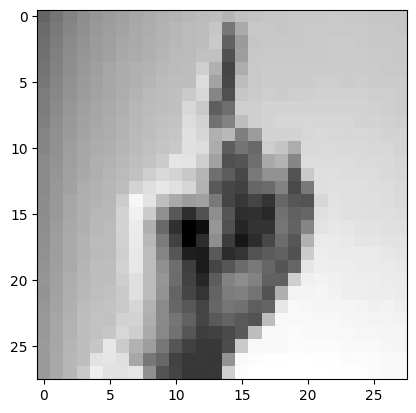

In [9]:
image = F.to_pil_image(x_0)
plt.imshow(image, cmap = 'gray')

### RandomResizeCrop

In [10]:
trans = transforms.Compose([
  transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale = (.7, 1), ratio = (1,1))
])

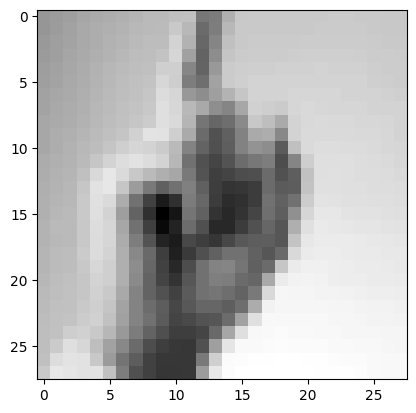

In [11]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

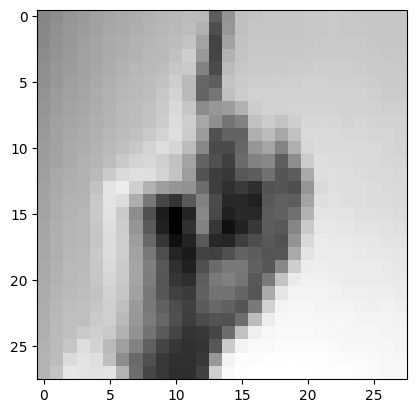

In [12]:
# transforms을 할 때마다 약간 다른 iamge return 
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### RandomHorizontalFlip

In [13]:
trans = transforms.Compose([
  transforms.RandomHorizontalFlip()
])

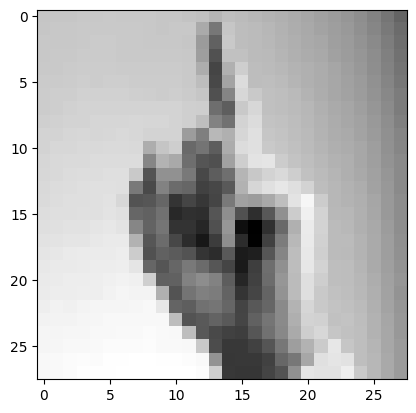

In [14]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap = 'gray')

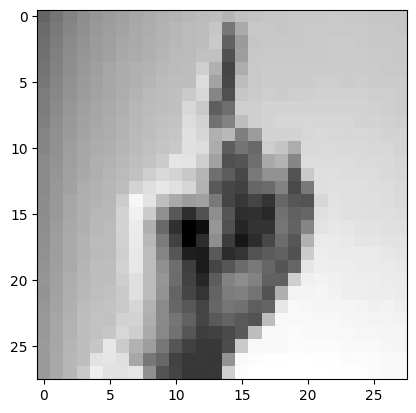

In [15]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap = 'gray')

### RandomRotation

In [16]:
trans = transforms.Compose([
  transforms.RandomRotation(10)
])

### ColorJitter
- brightness
- contrast
- saturation
- hue

In [17]:
brightness = .2  # Change to be from 0 to 1
contrast = .5  # Change to be from 0 to 1

trans = transforms.Compose([
    transforms.ColorJitter(brightness=brightness, contrast=contrast)
])

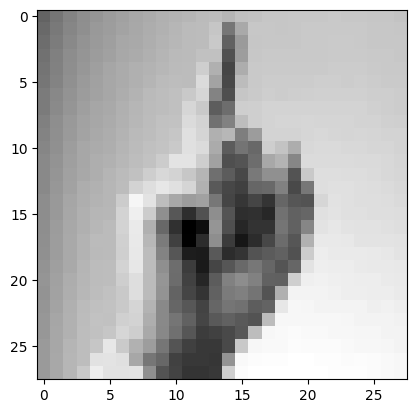

In [18]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### Compose

In [19]:
random_transforms = transforms.Compose([
    #transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])

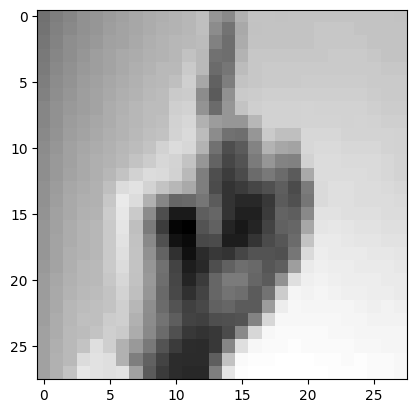

In [20]:
new_x_0 = random_transforms(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### Training with Augmentation

In [30]:
## accuracy function 
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item() # pred와 y가 동등한 것의 합계를 구해서 정확도 계산 
    return correct / N

In [31]:
def train():
  loss = 0
  acc = 0
  
  for x, y in train_loader:
    output = model(random_transforms(x))
    optimizer.zero_grad()
    batch_loss = loss_fn(output, y)
    batch_loss.backward()
    optimizer.step()
    
    loss += batch_loss.item() # python의 float 형태로 전달
    acc += get_batch_accuracy(output, y, train_n)
    
  print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, acc))

In [32]:
def validate():
  loss = 0
  acc = 0
  
  model.eval()
  with torch.no_grad():
    for x, y in valid_loader:
      output = model(x)
      
      loss += loss_fn(output, y).item()
      acc += get_batch_accuracy(output, y, valid_n)
      
  print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, acc))

In [33]:
EPOCHS = 100

for epoch in range(EPOCHS):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 739.8232 Accuracy: 0.7618
Valid - Loss: 207.2099 Accuracy: 0.6822
Epoch: 1
Train - Loss: 723.3928 Accuracy: 0.7628
Valid - Loss: 202.7022 Accuracy: 0.6842
Epoch: 2
Train - Loss: 724.7031 Accuracy: 0.7642
Valid - Loss: 205.5032 Accuracy: 0.6733
Epoch: 3
Train - Loss: 723.3027 Accuracy: 0.7654
Valid - Loss: 201.3943 Accuracy: 0.6847
Epoch: 4
Train - Loss: 702.0689 Accuracy: 0.7735
Valid - Loss: 202.4245 Accuracy: 0.6796
Epoch: 5
Train - Loss: 695.3163 Accuracy: 0.7760
Valid - Loss: 197.4729 Accuracy: 0.6967
Epoch: 6
Train - Loss: 680.5941 Accuracy: 0.7792
Valid - Loss: 198.0044 Accuracy: 0.6870
Epoch: 7
Train - Loss: 679.6194 Accuracy: 0.7810
Valid - Loss: 195.3063 Accuracy: 0.6992
Epoch: 8
Train - Loss: 671.5562 Accuracy: 0.7859
Valid - Loss: 191.5140 Accuracy: 0.7011
Epoch: 9
Train - Loss: 667.8717 Accuracy: 0.7882
Valid - Loss: 190.9192 Accuracy: 0.6981
Epoch: 10
Train - Loss: 666.6158 Accuracy: 0.7869
Valid - Loss: 188.9970 Accuracy: 0.7026
Epoch: 11
Train - Lo